## Robust PCA for video surveillance 

Principal Component Analysis (PCA) retains an approximation of an original dataset $X$ by focusing on the largest singular values. Such an order $K$ approximation can be obtained from the singular value decomposition $\boldsymbol U \boldsymbol \Sigma \boldsymbol V^T$ by truncating $\boldsymbol U$ to the first $K$ columns, retaining the $K\times K$ diagonal matrix $\boldsymbol \Sigma_k$ as well as the first $K$ rows of $\boldsymbol V^T$, $\boldsymbol V_k^T$, and writing the approximation as $\boldsymbol U_k \boldsymbol \Sigma_k \boldsymbol V^T_k$. This approach is particularly efficient when each of the feature vectors (or images in this case) are close to each other. When there is sharp variations across images, such as when an object appears, move throughout the images and then dissapears, a simple PCA does not suffice anymore and one might want to extend it to something more robust. The escalator sequence below is an example of such sequence. 

(20800,)


(20800, 200)

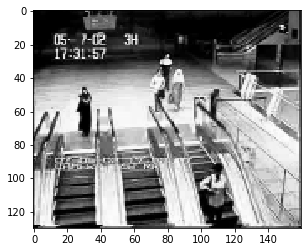

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from fbpca import pca

# read video

import scipy.io
movie = scipy.io.loadmat('escalator_data.mat')
#frame0 = 
print(np.shape(movie['X'][:,0]))

plt.imshow(movie['X'][:,0].reshape((160,130)).swapaxes(0, 1), cmap='gray')
X = movie["X"]

The idea of Robust PCA is to add a "sparse" component to the traditional PCA decomposition. Given a collection of images that we store as the columns of the matrix $X$, one then looks for a decomposition
 
\begin{align} 
\boldsymbol X = \boldsymbol Y + \boldsymbol S
\end{align}

Where $Y$ is a matrix which encode the original PCA model, and thus encodes the part of the images that remains approximately constant throughout the sequence, and $\boldsymbol S$ is the sparse part (i.e a sequence of images that are varying through the sequence but only at a precise position in the images, that is to say with most of the pixels being zero). To recover each part one approach is to proceed as follows, see [Candes et al.](https://arxiv.org/pdf/0912.3599.pdf)

We let $\mu$ to denote the parameter that controls the amount of dara we want to store in the sparse foreground extraction part, $\boldsymbol S$. The algorithm proceeds as follows


__Initialize__ $Y$, $S$ to $0$

__Step 1.__ Compute the truncated SVD of the matrix $X - S - \mu^{-1}Y$, i.e. let $X - S - \mu^{-1}Y = U\Sigma V^T$. The truncated SVD is then obtained by replacing the diagonal matrix of singular values with the truncation 
$$ 
\sigma \leftarrow \text{sign}(\sigma)\max(|\sigma| - \mu, 0)  
$$

and store it in $L$, $L = SVD_{\mu}(X - S - \mu^{-1}Y)$ 



__Step 2.__ Apply the thresholding operator $f(x) = \text{sign}(x)\max(|x| - \lambda \mu, 0) $ with threshold $\lambda\mu$ to the entries of the matrix $X - L + \mu^{-1}Y$

__Step 3.__ Update the matrix $Y$ as $Y \leftarrow Y + \mu(X - L - S)$


A good approach to initialize the parameters is to take $lambda = 1/\max(m,n)$ where $\max(m,n)$ is the max number of rows or columns of the data matrix. We can then set $\mu = 0.25*(m*n)/(\sum_{i,j}|X_ij|)$. One can then terminate the algorithm when $\|X-L-S\|_F \leq  \delta \|X\|_F$ where $\|X\|_F$ is the Frobenius norm of the matrix and $\delta$ can be taken for example as $10^{-7}$. 


Additional indications: if computing the full SVD from linalg is too expensive, you can replace it with the fast randomized PCA from facebook (see [fbpca](https://fbpca.readthedocs.io/en/latest/)) or a sparse SVD.


### Complete the code below which separates the sparse part from the PCA decomposition

In [10]:
#from __future__ import division
import numpy as np 
from scipy.sparse.linalg import svds




def robustPCA(X, delta=1e-6, mu=None, maxiter=500):

    '''
    The function should return a PCA like part stored in 'L' with only a few singular values 
    that are non zero and a sparse sequence 'S' in which the images are black except w very 
    limited number of pixels
    '''
    
    # Initialize the tuning parameters.
    lam = max(X.shape)
    shape = X.shape
    if mu is None:
        mu = (0.25*(X.shape[0])*(X.shape[1]))/(np.absolute(X).sum())
        # complete with your value for mu
        
    # Convergence criterion.
    norm = np.sum(X ** 2)

    # Iterate.
    i = 0
    rank = np.min(shape)
    S = np.zeros(shape)
    Y = np.zeros(shape)
    while i < max(maxiter, 1):
        # Step 1. Compute and truncate the SVD
        U,s,Va = pca(X-S-(mu**-1)*Y)
        s.reshape(s.shape[0],1)
        # truncation
        s = np.multiply(np.sign(s), np.maximum(np.abs(s) - mu, 0))
        s = s * np.identity(len(s))
        L = np.dot(np.dot(U,s),Va)
        
        # Step 2. Truncate the entries of X - L + mu^(-1)Y 
        S = X-L+(mu**-1)*Y
        S = np.multiply(np.sign(S), np.maximum(np.abs(S) - mu, 0))
        
        
        # Step 3. Update the matrix Y
        Y = Y + mu*(X-L-S)
        

        # Convergence criterion
        err = np.sqrt(np.sum((X-L-S) ** 2) / norm)
        if err < delta:
            break
            i += 1

        if i >= maxiter:
            break
        
    return L, S

Apply your function to the escalator sequence and display the result on at least one frame. Use subplot to display the extracted background and its corresponding foreground side by side. 

In [11]:
# put your code here
L,s = robustPCA(X, delta=1e-6, mu=None, maxiter=500)

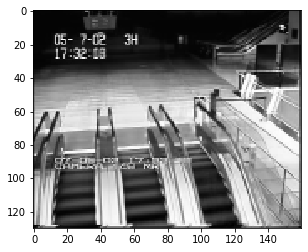

In [12]:
plt.imshow(L[:,100].reshape((160,130)).swapaxes(0, 1), cmap='gray')

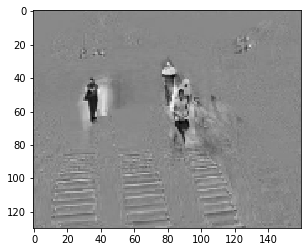

In [13]:
plt.imshow(s[:,20].reshape((160,130)).swapaxes(0, 1), cmap='gray')